# Process EDX
This script imports the collected EDX spectra into the *data* dataframe and also saves the spectra as *csv* file for later use. Therefore, at first a special particle/field string is determined, which corresponds to the filename of the EDX spectrum file ([Filestrings](#Filestrings)). Then, a function is defined to import a single spectra ([EDX file import](#EDX-file-import)), after which the spectra for all particles are imported into an array ([Spectra import](#Spectra-import)). Finally, the obtained array is saved as an EDX file ([Export results](#Export-results)).

#### Preparation
As this script is designed to be used both externally and stand-alone, at first some required modules are loaded. Then, some global variables are checked whether they have been created externally and if note, are assigned.

In [4]:
# Import modules
import numpy as np
import pandas as pd
import struct
from os import listdir, path

In [13]:
if False:
    del directory, stub, data
    del EDX_save, EDX_channels
    
# directory
try:
    directory
except NameError:
    directory = "E:\\PA_UC\\"
    print("Directory not specified, set to "+directory)

# stub
try:
    stub
except NameError:
    stub = 1
    print("Stub not specified, set to "+str(stub))
    
# data
try:
    data
except NameError:
    print("No data available, running ImportData:")
    %run ./ImportData.ipynb
    print("-----")
    
# EDX_save
try:
    EDX_save
except NameError:
    EDX_save = False
    print("EDX_save not specified, set to "+str(EDX_save))
    
# EDX_channels
try:
    EDX_channels
except NameError:
    EDX_channels = 2086
    print("EDX_channels not specified, set to "+str(EDX_channels))

Directory not specified, set to E:\PA_UC\
Stub not specified, set to 4
No data available, running ImportData:
File: E:\PA_UC\pa_uc.csv
Date: 13.12.2016
Voltage: 10.0 kV
Magnification: 2500x
Measurement time: 30.0 s
Number of columns: 28
Number of particles: 3639
Particles on stub 4: 308
-----
EDX_save not specified, set to False
EDX_channels not specified, set to 2086


#### Filestrings
The spectra files are saved in a folder and are named according to *ffffpppp.spc*, where *ffff* is the field number and *pppp* is the particle number on field *ffff*. However, as the particle number is not obtained during the data import, it is determined using the following script.

In [14]:
strStub = 'stub{num:02d}'.format(num=stub)
fld_prev = 1
partnum = 0
fldpart = np.array([])

for i in range(len(data)):
    fld = int(data.iloc[i]["fieldnum"])
    if fld!=fld_prev:
        # New field, reset particle counter
        partnum=1
        fld_prev = fld
    else:
        # Field with more than 1 particle
        partnum += 1
    fldpart = np.append(fldpart, "{0:04d}{1:04d}".format(fld, partnum))

#print(fldpart)    

#### EDX file import
The EDX spectra are saved as binary *spc* files in the */stub##/spc/* directory. A function is defined which opens a single spectra, reads out the relevant bytes and return a numpy array containing the measured intensities. When the requested file doesn't exists, only zeros are returned.

In [15]:
def EDXimport(PartID=0):
    global N_EDX
    EDXfile = directory+strStub+"\\spc\\"+fldpart[PartID]+".spc"
    
    if(path.isfile(EDXfile)==False):
        return np.zeros(EDX_channels)
    
    N_EDX += 1
    with open(EDXfile, 'rb') as f:
        spectrum = np.zeros([EDX_channels],dtype="uint32")
        i = 0

        f.seek(3848)
        byte = f.read(4)    
        while byte and i<EDX_channels:
            spectrum[i] = struct.unpack('I', byte)[0]
            byte = f.read(4)
            i = i + 1
        
    return spectrum

#print(EDXimport())

#### Spectra import
After preparing the data and functions, the spectra for all particles can now be imported into the dataframe.

In [16]:
EDX = np.zeros([EDX_channels])
N_EDX = 0
for i in range(len(data)):
    EDX = np.column_stack((EDX, EDXimport(i)))

EDX = np.delete(EDX, (0), axis=1)
EDX = np.transpose(EDX)
data["EDX"] = EDX.tolist()

print("Number of EDX spectra: "+str(N_EDX))

Number of EDX spectra: 308


#### Export results
Save the collected spectra in a csv file located in the main stub folder.

In [197]:
if EDX_save:
    np.savetxt(directory+strStub+"\\EDX.csv", EDX, fmt="%1.1d", delimiter=",")
    print("EDX spectra saved to "+directory+strStub+"\\EDX.csv")

#### Get intensitities
The total intensity measured in a number of regions in the EDX spectra are obtained and assigned to some elements.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [18]:
def EDXGetElement(E, dx=9):
    I = np.sum(EDX[:,E-dx:E+dx], axis=1)

    ax.add_patch(
        patches.Rectangle(
            (E-dx,0), 
            width = (2*dx), 
            height = max(y),
            linewidth=1,
            edgecolor='b',
            facecolor='none'
        )
    )
    
    return I

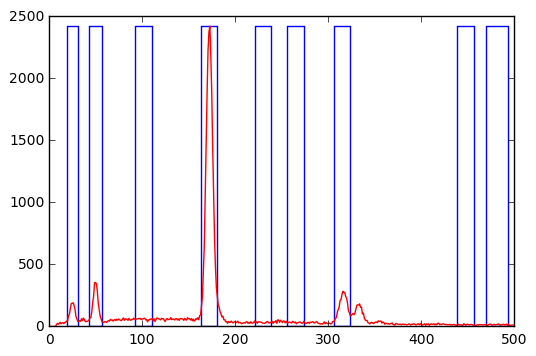

In [19]:
y = EDX[4,0:500]
fig,ax = plt.subplots(1)
ax.plot(range(len(y)), y, 'r-')

data["C"] = EDXGetElement(25, 6)
data["O"] = EDXGetElement(50, 7)
data["Na"] = EDXGetElement(102)
data["Si"] = EDXGetElement(172)
data["S"] = EDXGetElement(230)
data["Cl"] = EDXGetElement(265)
data["U"] = EDXGetElement(315)
data["Ba"] = EDXGetElement(448)
data["Ce"] = EDXGetElement(482, 12)
data["Fe"] = EDXGetElement(638)

plt.show()

#### Pair plot
Prepare a pair plot to visualize any correclation or goups of elements.

C:\miniconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


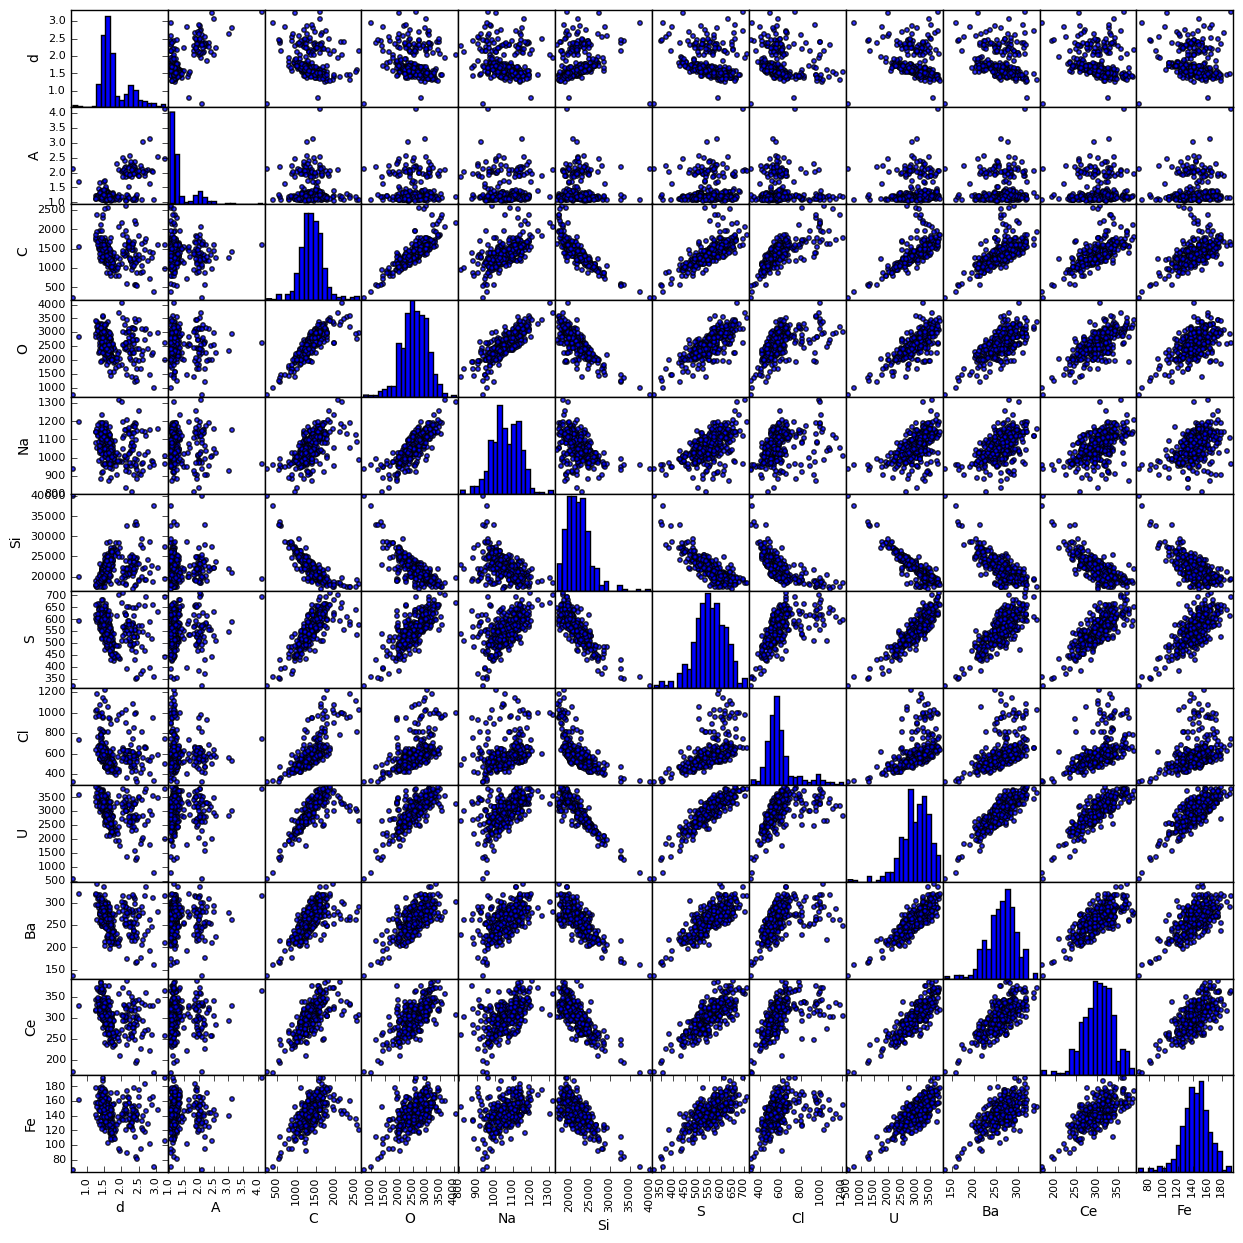

In [23]:
from pandas.tools.plotting import scatter_matrix

columns = ["d", "A", "C", "O", "Na", "Si", "S", "Cl", "U", "Ba", "Ce", "Fe"]
test = data.loc[:,columns]

grr = pd.scatter_matrix(
    test, 
    figsize=(15, 15), 
    marker='o',
    hist_kwds={'bins': 20}, 
    s=10, 
    alpha=.8, 
)